# Forecasting the price of Bitcoin

## Project Outline

The purpose of this project is to forecast the trend of Bitcoin by applying two time series machine learning models on 5-year historical data, namely the **VAR**, **SARIMA** and **Facebook Prophet** models.

For the purposes of this project, 5Y daily historical data spanning from June 2016 to June 2021 of [Bitcoin prices (in USD)](https://finance.yahoo.com/quote/BTC-USD/history?period1=1590969600&period2=1625011200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) and the [US Dollar index](https://finance.yahoo.com/quote/DX-Y.NYB/history?p=DX-Y.NYB) were extracted from *Yahoo Finance*. There exists an implicit hypothesis that BTC and USD are inversely correlated because of the prevailing view that BTC serves as a hedge against the Dollar, which will also be explored.

The implementation of this project draws upon several references & material from Marco Santos' article published at *Towards Data Science* in 2019 [here](https://towardsdatascience.com/predicting-prices-of-bitcoin-with-machine-learning-3e83bb4dd35f).

### Preparing the Data

The first phase of this project involves preparing and processing the obtained data to facilitate a preliminary overview of Bitcoin and the Dollar. We also want to identify and visualize any pertinent measures and characteristics that can value-add to the forecasting process.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Generating dataframes
btc = pd.read_csv("data/BTC-USD.csv", index_col = 0, parse_dates = True)
usd = pd.read_csv("data/DXY.csv", index_col = 0, parse_dates = True)

In [2]:
# Displaying BTC dataframe
btc = btc.drop(btc.columns[[0,1,2,4,5]], axis = 1)
btc.describe()

,Close
count,1852.000000
mean,10477.785109
std,12842.363423
min,536.919983
25%,3584.833740
50%,7299.333496
75%,10324.330566
max,63503.457031


In [3]:
# Displaying USD dataframe
usd = usd.drop(usd.columns[[0,1,2,4,5]], axis=1)
usd.describe()

,Close
count,1267.000000
mean,95.546504
std,3.256418
min,88.589996
25%,93.120003
50%,95.959999
75%,97.699997
max,103.290001


In [4]:
# Combining the data to generate an overview
join_df = btc
for x in join_df.index.values:
    for x2 in usd.index.values:
        if x == x2:
            itemindex = np.where(usd.index == x2)[0][0]
            val = usd.at[x2, "Close"]
            join_df.at[x, "USD"] = val
join_df.head()

,Close,USD
Date,,
2016-06-01,536.919983,95.459999
2016-06-02,537.971985,95.559998
2016-06-03,569.193970,94.029999
2016-06-04,572.726990,NaN
2016-06-05,574.976990,NaN


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

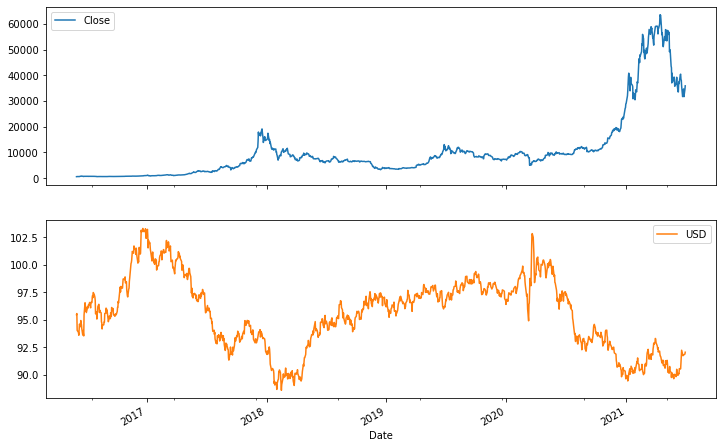

In [5]:
# Visualizing the overview of combined data
join_df = join_df.dropna()
join_df.plot(subplots = True, figsize = (12,8))

A quick glance suggests there is evidence of an inverse relationship between BTC and the Dollar, as can be seen in the corresponding periods 2017-2018 and 2020-2021, but this is not entirely clear due to the disproportionate volatility in the price of BTC. We can investigate further by evaluating several key statistics that can be derived by  the following as outlined by [Jeffrey Yau in 2017](https://www.youtube.com/watch?v=_vQ0W_qXMxk&t=1157s).

In [6]:
def plotcharts(y, title, lags=None, figsize=(12,8)):
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight="bold")
    y.plot(ax=hist_ax, kind="hist", bins=25)
    hist_ax.set_title("Histogram")
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

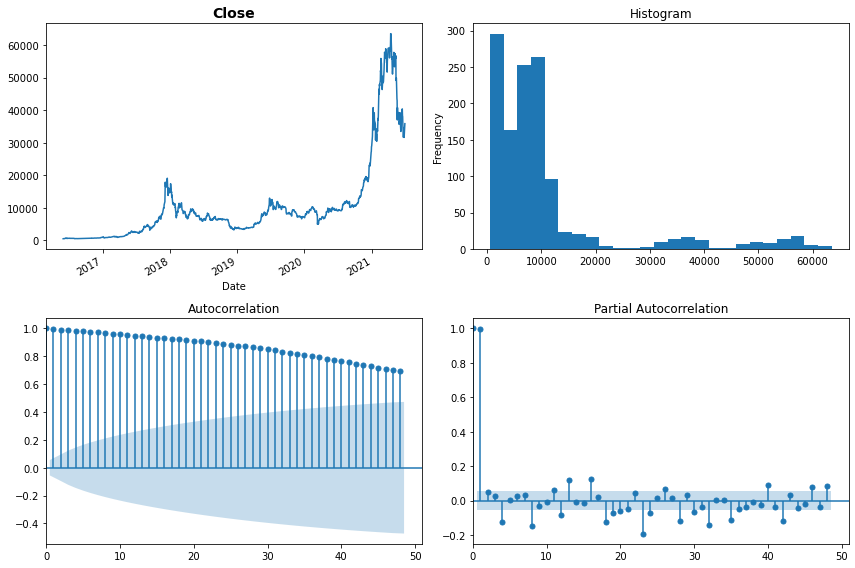

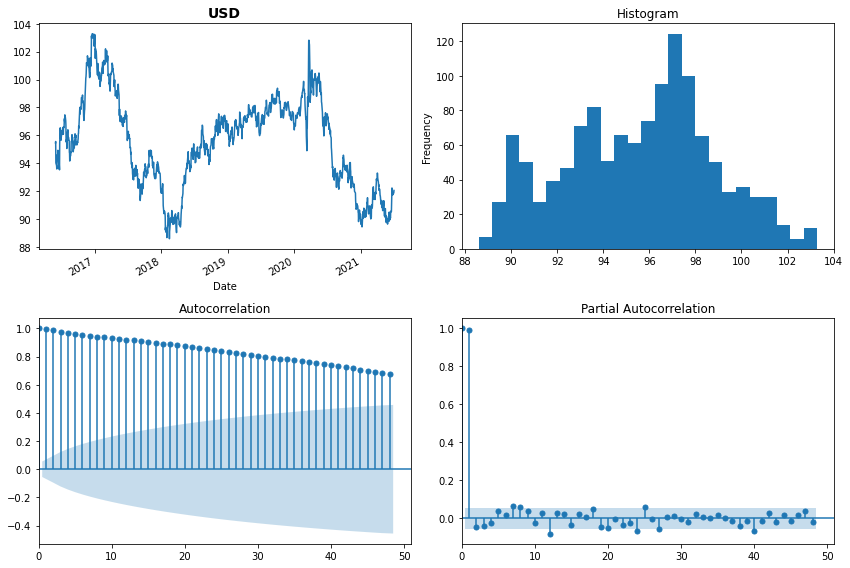

In [7]:
series = join_df

num_var = len(series.iloc[1,:])
for i in range(0, num_var):
    plotcharts(series.iloc[:,i].dropna(), title=series.columns[i], lags=48)

The above plots provide several diagnostics that better describe the behavior of BTC over this time series. Of particular note to us would be the measures of autocorrelation, which will play an important role in evaluating our current data models.

### Autocorrelation Function (ACF)

The ACF outputs a coefficient that measures the degree of correlation of the same variables between two successive time intervals, and is given by: 

\begin{equation*} \mbox{Corr}(y_{t},y_{t-k}). \end{equation*}

ACF returns a value between -1 (perfectly inversely autocorrelated) and 1 (perfectly autocorrelated), where ***k*** is the time interval, or also referred to as "lag". In other words, a positively autocorrelated variable will more likely increase when it has been increasing, and vice versa. The reverse is true for a negatively autocorrelated variable, and an autocorrelation of 0 indicates complete uncorrelation. 

A key takeaway of ACF is to measure the linear relationship between an observation at various points in time. Since we are working with daily data, we also use the **partial autocorrelation function (PACF)** to identify the order of the autoregression relationship. PACF is obtained by filtering out the linear influence of random observations that lie in between a specified lag, and essentially computes the autocorrelation of a transformed time series. Without getting into the granular details, the ACF shows us which day in the past correlates the most with the current day with respect to the days in between, while PACF shows us which day in the past correlates directly to the current day by *ignoring* the days in between.

More on ACF & PACF [here](https://online.stat.psu.edu/stat501/lesson/14/14.1).

### Stationarity & Normalization

It turns out that the observations we have so far is not yet ideal to be piped into our prediction models just yet, and this is because our time series data is currently **non-stationary**. What this means is that the current state of our historical prices data does not take into account the following factors: *trend, seasonality, cyclicality*, and other irregularities that can skew our models.

In order to make our data stationary, we normalize our data by applying a *logarithmic* transformation. This facilitates a more uniform distribution in BTC prices that is more normally distributed and adheres to the Central Limit Theorem (CLT). In other words, we effectively eliminate the inherent multiplicative factor of asset returns.

,Close,USD
0,0.498294,0.055118
1,0.419085,0.741468
2,0.404132,0.438105
3,0.469173,0.385398
4,0.426046,0.596196


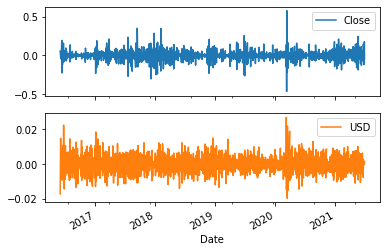

In [8]:
# Applying log transformation
log = pd.DataFrame(np.log(series))

# Differencing the log values
log_diff = log.diff().dropna()
log_diff = log_diff.diff().dropna()
log_diff.plot(subplots = True)

# Normalizing using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()

join_norm = pd.DataFrame(norm.fit_transform(log_diff), columns = log_diff.columns)
join_norm.head()

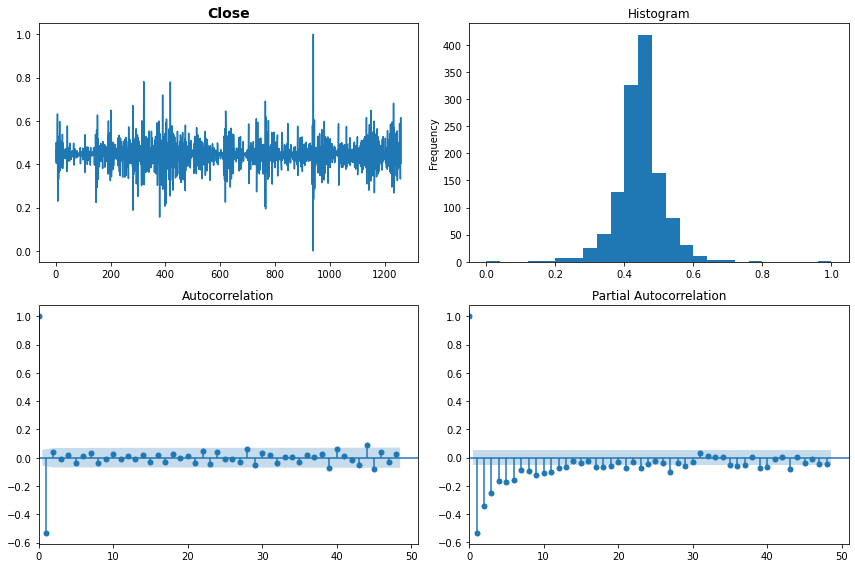

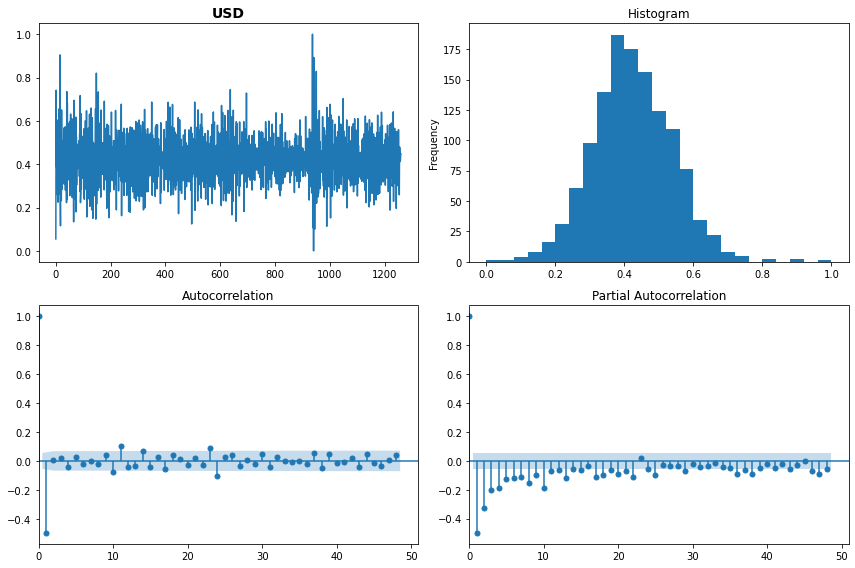

In [9]:
num_var = len(join_norm.iloc[1, :])
for i in range(0, num_var):
    plotcharts(join_norm.iloc[:, i].dropna(), title = join_norm.columns[i], lags = 48)

Above we can visualize our normalized data and use the ACF and PACF to select and optimize the parameters to be fed to our learning models. 

We also run the [Dickey-Fuller test](https://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/) to determine if our transformed data qualifies as being stationary. This is verified by computing a p-value that is indeed less than the critical threshold of 5% (the closer to 0 the better). We also want to minimize the **AIC score** as our objective for the purposes of optimizing our training parameters, more on that later.

In [10]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)
        
ad_test(log_diff["Close"])
print("--------------------------------------------")
ad_test(log_diff["USD"])

1. ADF :  -12.23491265913313
2. P-Value :  1.0333998708515111e-22
3. Num Of Lags :  23
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  1237
5. Critical Values : 
	 1% :  -3.4356474307506084
	 5% :  -2.8638793281844253
	 10% :  -2.5680154897465575
--------------------------------------------
1. ADF :  -15.011567766384966
2. P-Value :  1.0536316087250117e-27
3. Num Of Lags :  21
4. Num of Observations Used For ADF Regression and Critical Values Calculation :  1239
5. Critical Values : 
	 1% :  -3.435638861796935
	 5% :  -2.863875547501718
	 10% :  -2.5680134763122906


Now that the data has satisfied the stationary condition i.e. our p-values are very close to 0, it can be fed to our learning models.

### Vector Autoregressive Model (VAR)

The VAR model is a stochastic form of *autoregression* model (AR) used for multivariate time series. For the mathematically-inclined, VAR with an order of *p*, denoted as VAR(p), is expressed as follows:
\begin{equation*}
x_{t,p} = \alpha_{p} + \phi_{p1} x_{t−1,1} + \phi_{p2}x_{t−1,2} + \phi_{p3}x_{t−1,3} + w_{t,p}
\end{equation*}

In general, each variable is a linear function where the first *p* lags of each variable would be used as regression predictors for itself. We use VAR to capture the relationship between the various variables that make up the forecast.

In [11]:
# Splitting dataset into train and test subsets
n_obs = 9
# Forecast n_obs days forward by looking at previous n_obs days
train, test = log_diff[:-n_obs], log_diff[-n_obs:]
log_diff.head()

,Close,USD
Date,,
2016-06-03,0.054457,-0.017187
2016-06-06,-0.028107,0.014757
2016-06-07,-0.043694,0.000638
2016-06-08,0.024103,-0.001815
2016-06-09,-0.020851,0.007996


In [12]:
# Fitting the VAR model
from statsmodels.tsa.api import VAR

model = VAR(log_diff)
results = model.fit(maxlags = 22, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Jul, 2021
Time:                     22:14:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.7139
Nobs:                     1239.00    HQIC:                  -16.9461
Log likelihood:           7158.64    FPE:                3.79909e-08
AIC:                     -17.0860    Det(Omega_mle):     3.53746e-08
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.000039         0.001407           -0.028           0.978
L1.Close         -0.983459         0.028910          -34.018           0.000
L1.USD            0.458689         0.374507            1.225           0.221

The VAR model outputs an evaluation of the coefficients, standard deviation, probabilities as well as other statistical metrics. Notably, the correlation matrix at the bottom asserts that there indeed exists an inverse correlation with the USD. 

With this in mind, we can run the forecast and test it against the actual values from our dataset i.e. 9 days to the end of our dataset period.

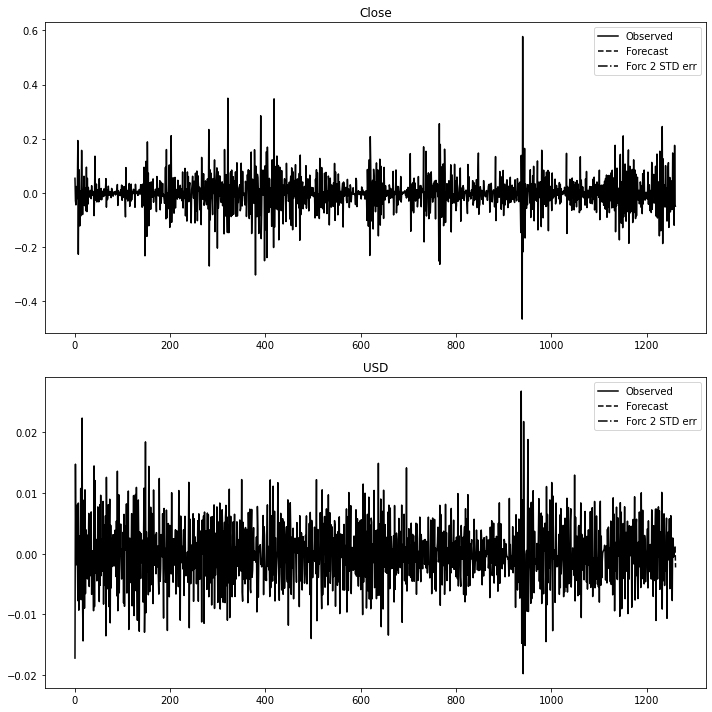

In [13]:
lag_order = results.k_ar
predicted = results.forecast(log_diff.values[-lag_order:],n_obs)
forecast = pd.DataFrame(predicted, index = log_diff.index[-n_obs:], columns = log_diff.columns)


# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

In [14]:
# Undoing the Differencing Transformation
def invert_transformation(df, df_forecast, second_diff):
    for col in df.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (df[col].iloc[-1] - df[col].iloc[-2]) + df_forecast[str(col)].cumsum()
        # Undo the 1st Differencing
        df_forecast[str(col)] = df[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

forecast_values = invert_transformation(train, forecast, second_diff=True)

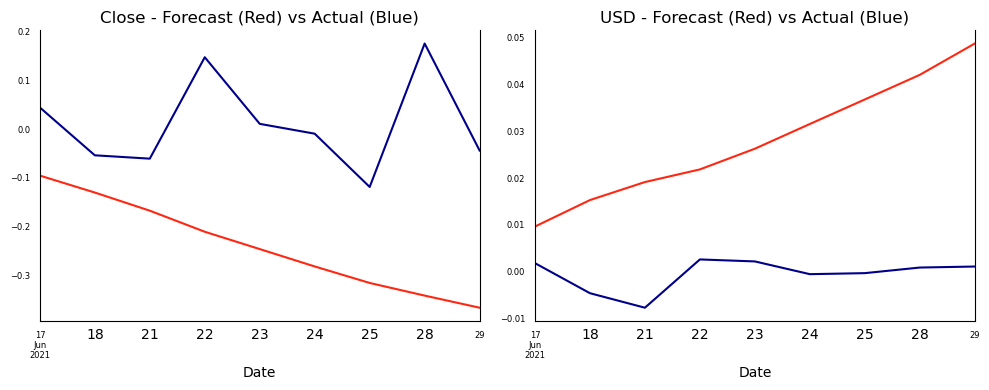

In [15]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(log_diff.columns)/2), ncols = 2, dpi = 100, figsize = (10,4))

for i, (col,ax) in enumerate(zip(log_diff.columns, axes.flatten())):
    forecast_values[col].plot(color = '#FF2712', legend = False, ax = ax).autoscale(axis =' x',tight = True)
    test[col].plot(color = '#00008B', legend = False, ax = ax)

    ax.set_title(col + ' - Forecast (Red) vs Actual (Blue)')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from numpy import asarray as arr
mse = mean_squared_error(test, forecast_values)
print("\nMean Squared Error: ", mse)


Mean Squared Error:  0.04036391557361992


####  Results & Observations

The VAR model is admittedly not very reliable as a forecasting tool for both BTC and the USD. The findings using 9-day period observation in our scenario yielded the best (lowest) mean square error, which means at best, it can only be used to predict a very short term forecast of the (logarithmic) trend in both BTC and USD. Even so, results are inconsistent across different time periods and n-day observations. This becomes even more problematic due to the fact that USD has historically been fluctuating wthin a relatively stable channel over the years since the existence of Bitcoin. The reason behind this becomes quickly apparent in that it does not seem to reliably capture volatility arising from seasonality or cyclicality. 

While the VAR fails to deliver a robust prediction of asset (BTC & USD) prices, we can, however, statistically affirm that there is some underlying negative correlation between BTC and USD, though this relationship is objectively not very strong, nor can it imply causation.

### SARIMA Modeling

SARIMA, or *seasonal autoregressive integrated moving average* model is built upon **ARIMA** but with the concept of seasonal trends being taken into account. ARIMA is composed of three terms:
* **AR(p)**, the *autoregression* model where *p* is an integer that denotes how many lagged series are going to be used for the forecasting.
* **I(d)**, which stands for *'Integrated'*, is the use of differencing with order of *d* to make our data stationary.
* **MA(q)**, the *moving average* model, and *q* is the number of lagged forecast error terms in the prediction equation.

Here is where ACF and PACF plots generated earlier are used to determine the values for *p* and *q* for the fitting of our SARIMA models. Then, we determine the most optimal paramters to be used for our forecasting by computing and choosing the ones with the lowest [**AIC score**](https://timeseriesreasoning.com/contents/akaike-information-criterion/), which we have already obtained earlier. More information on SARIMA and ARIMA can be found from the following articles by [Harsh Patel](https://becominghuman.ai/what-is-arima-and-sarima-model-10972b5e13c0), [Kenneth Foo](https://medium.com/@kfoofw/seasonal-lags-sarima-model-fa671a858729) and [Omega Markos](https://medium.com/@kfoofw/seasonal-lags-sarima-model-fa671a858729).

Again, we first normalize the BTC dataset and feed in the corresponding parameters (more on that [here](https://towardsdatascience.com/predicting-prices-of-bitcoin-with-machine-learning-3e83bb4dd35f)).

In [17]:
# Log transformation of BTC
btc_log = pd.DataFrame(np.log(btc.Close))

# Differencing the log values
log_diff = btc_log.diff().dropna()

# Using the Dickey-Fuller test to check for stationarity
results = adfuller(log_diff.Close)

# Splitting dataset for training and testing (80/20)
index = round(len(btc)*.80)
train = btc_log.iloc[:index]
test = btc_log.iloc[index:]

sarima = sm.tsa.statespace.SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = sarima.fit()
# output.summary()

In [18]:
# SARIMA model diagnostics 
# output.plot_diagnostics(figsize=(15,8))
# plt.show()

To visualize the model's performance, we want to evaluate the forecast against our test sample, again following the 80/20 split rule. In this case, it will be more meaningful to reverse the log transformation to draw direct comparison with the actual price of BTC.

In [19]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Reversing log transformation
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start = pd.to_datetime('2016-06'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index = train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index = train.index))

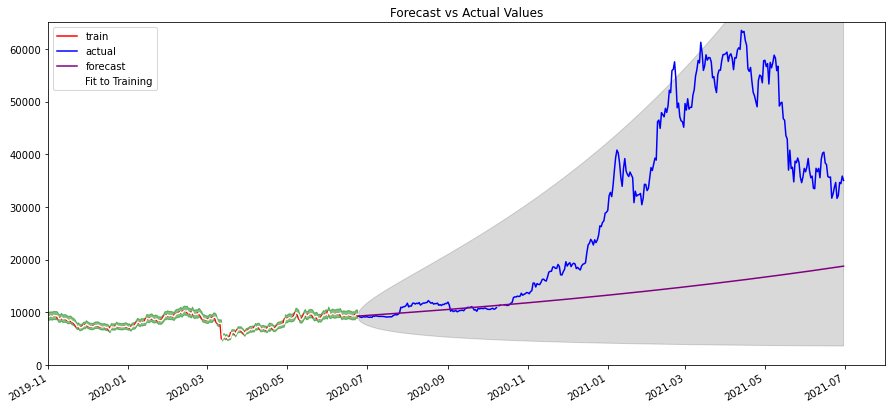

In [20]:
rcParams['figure.figsize'] = 15, 7

# Plotting the training set, test set, forecast, and confidence interval.
plt.plot(etrain, label='train', color='r')
plt.plot(etest, label='actual', color='b')
plt.plot(fc_series, label='forecast', color='purple')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='white')

# Visualizing the confidence interval
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the time period
plt.xlim(['2019-11', '2021-08'])
plt.ylim([0, 65000])

plt.title('Forecast vs Actual Values')
plt.legend()
plt.show()

In [21]:
forecast = pred
actual_val = etrain.Close

# Calculating MSE
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  341.5809977617711


#### Results & Observations

Here we see that SARIMA does correctly deduce the uptrend in price of BTC, and that the confidence interval as shaded in gray captures the implied volatility range in prices reasonably well. Promisingly, there is visual evidence to suggest SARIMA can provide a decent estimation to the baseline trend, as depicted by the forecasted values in purple. We do note, however, that the confidence interval becomes exponentially larger the further we forecast into the future. With that, we can try to use SARIMA to predict the next 30 days into the future, which is a reasonable timeframe for the model.

In [22]:
# Fitting entire dataset to model
model = sm.tsa.statespace.SARIMAX(btc_log, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [23]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)

# Transforming values back
pred_fut = np.exp(future.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = future.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

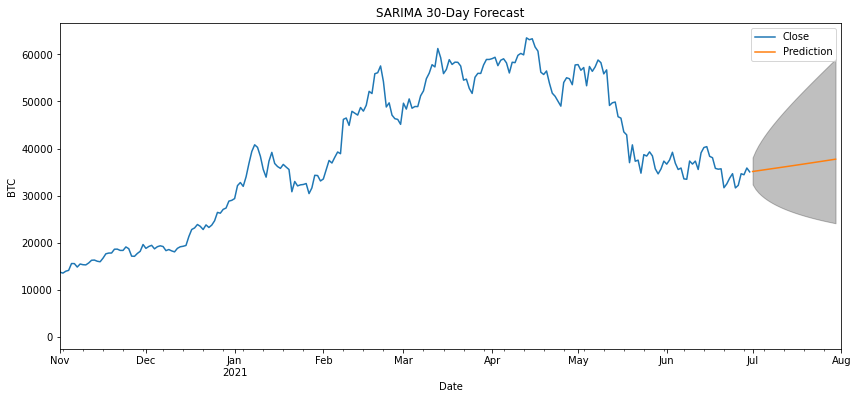

In [24]:
# Plotting the prices up to the most recent
ax = np.exp(btc_log).plot(label='Actual', figsize=(14,6))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Prediction')


# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('BTC')
ax.set_xlim(['2020-11','2021-08'])

plt.title('SARIMA 30-Day Forecast')
plt.legend()
plt.show()

According to SARIMA, it seems we can expect the baseline trend to continue in an upward trajectory. However, there are definitely some caveats. First, we note that the confidence interval is very wide, being at a range between the low 20000s up to 60000 within the next month. Second, if we cross-validate the output here with our previous forecast, there is a discrepancy between the forecasts, which can be attributed to the bias towards the recent data where prices has surged, thus potentially skewing our future forecast. Nevertheless, we can conclude that the SARIMA expects BTC to tend towards the median price somewhere within the ballpark of \$40,000s.

(Note: As of 30th July 2021, BTC is hovering around US\$39,000, though it has mostly consistenly traded within the lower band of the forecasted confidence interval for the month.)

### Facebook Prophet

An alternative model that serves as a good comparison to the SARIMA is Facebook Prophet, which is available as an [open-source library](https://facebook.github.io/prophet/), and is known for its intuitive and ease of use. Under the hood, Prophet, like SARIMA, is designed to forecast non-linear trends that harbor strong seasonal variability, but it also has the added feature to handle outliers and utilizes an *additive regression model* unlike its ARIMA counterparts. This model can be represented by the following equation:
\begin{equation*}
y(t) = \text{trend}(t) + \text{seasonality}(t) + \text{holiday_effects}(t) + \text{noise}
\end{equation*}

An interesting component of Prophet is how it incorporates trend (be it linear or logistic) and seasonality to try to anticipate changes in trend trajectory by implementing a good balance of regularization, intuition behind the Fourier series, and dummy variables. More on Prophet can be found [here](https://www.youtube.com/watch?v=pOYAXv15r3A).

In [25]:
# Importing Prophet
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [26]:
# Function to fit model
def fit_model(df):
    m = Prophet(daily_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    return m, forecast, future

In [27]:
# Formatting data for Prophet
btc = pd.read_csv("data/BTC-USD.csv")
btc_price = btc.drop(btc.columns[[1,2,3,5,6]], axis=1)
btc_price.columns = ["ds","y"]
# btc_price.head()

In [28]:
model, forecast, future = fit_model(btc_price)

In [29]:
# future.tail()

In [30]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2216,2022-06-26,94164.306954,82350.009091,105889.192726
2217,2022-06-27,94411.176770,82250.924725,106036.659830
2218,2022-06-28,94613.006112,82398.557704,106690.206007
2219,2022-06-29,94804.229532,83025.691491,106299.416137
2220,2022-06-30,95068.096256,82939.087677,107662.962156


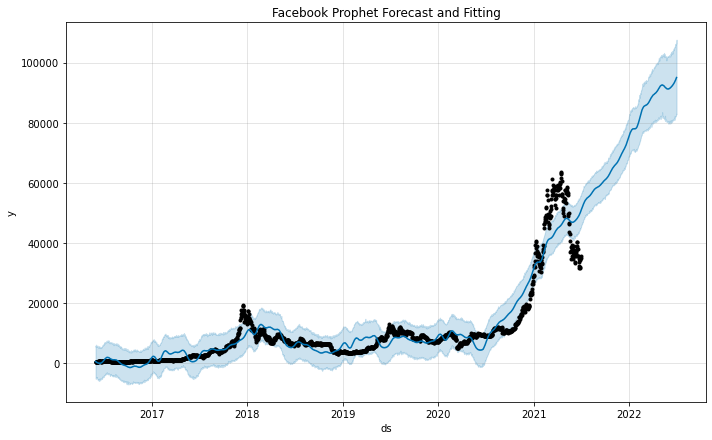

In [31]:
# Plotting the model
model.plot(forecast, uncertainty = True)
plt.title('Facebook Prophet Forecast and Fitting')
plt.show()

* Blue line: Forecasted price trend
* Black dots: Actual prices/observations
* Shaded region: Confidence interval

Interestingly, Prophet projects a far more optimistic outlook of BTC than SARIMA. Clearly there is a large skew to the upside projection owing to the surge in 2021, though Prophet did seem to correctly anticipate the move ahead of time. Looking at the previous years, there are periods where it did the same and quite reliably predicted a reversal, namely in Q3 2018 and Q3 2020. However, this is not always the case as there are clear signs where Prophet exhibits susceptibility to over-extrapolation and excessive trend-following, especially in periods of extreme volatility. To those who are more familiar with the technical trading landscape, Prophet seems to share some semblance with Bollinger Bands, though the two are technically very different in implementation.

We can attempt to reduce the recency bias by shortening the dataset to 3 years instead of 5, with the intuition that we want to capture more of the downward volatility rather than the dominant upward skew between 2016 and now.

In [32]:
# Fitting 3Y data
btc_y = pd.read_csv("data/BTC_3y.csv")
btc_price = btc_y.drop(btc.columns[[1,2,3,5,6]], axis=1)
btc_price.columns = ["ds","y"]

In [33]:
model, forecast, future = fit_model(btc_price)

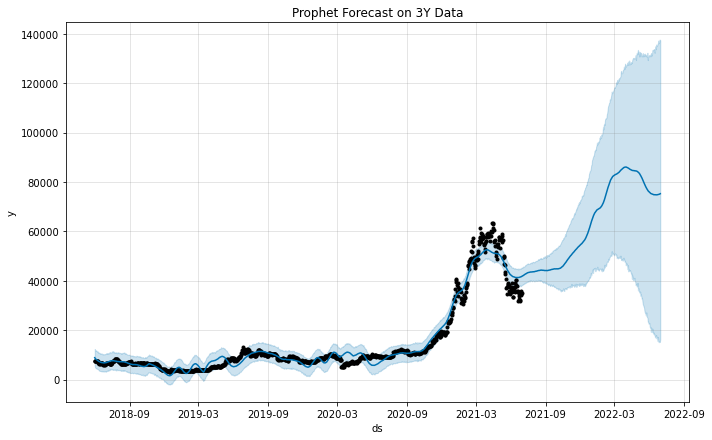

In [34]:
# Plotting the model
model.plot(forecast, uncertainty = True)
plt.title('Prophet Forecast on 3Y Data')
plt.show()

As expected, Prophet's outlook on BTC becomes more modest as the recent drawdown places more weight on its overall evaluation and forecasts. This also translates to higher uncertainty as observed from the widening confidence band.

Additionally, we can also use Prophet to forecast USD and see if can provide us with any additional insight. 

In [35]:
# Forecasting USD with Prophet
usd = pd.read_csv("data/DXY.csv")
usd_price = usd.drop(btc.columns[[1,2,3,5,6]], axis=1)
usd_price.columns = ["ds","y"]

In [36]:
model, forecast, future = fit_model(usd_price)

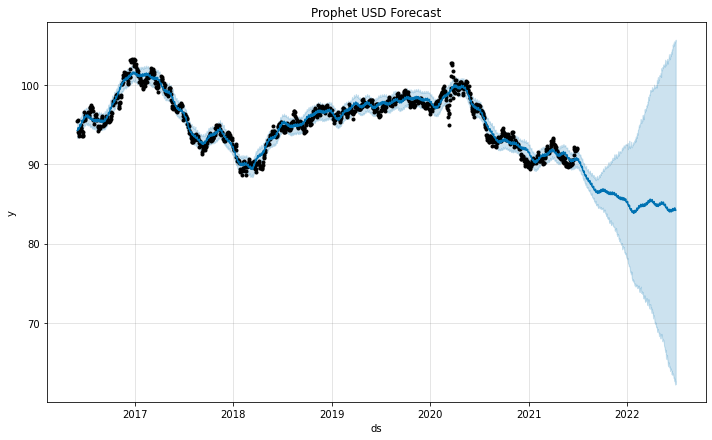

In [37]:
model.plot(forecast, uncertainty = True)
plt.title('Prophet USD Forecast')
plt.show()

Prophet predicts a slowly decreasing trend for the Dollar, but it also takes into account the USD's tendency to mean-revert around a tight channel and translates that into the form of a widening confidence interval i.e. higher uncertainty. Prophet's forecast for the USD also does indirectly imply an inverse correlation between the BTC and the Dollar, at least to an extent.

### Key Takeaways

A summary of our findings are as follows:
* VAR can at best only generate a short-term prediction (9 days in our case), and it evaluates a modest negative (inverse) correlation between BTC and USD.
* SARIMA forecasted a modest and smooth base-line uptrend in BTC, but it more readily accounts for volatility in the form of a wide confidence interval, which does seem to capture the implied volatility of BTC quite well. This uncertainty does increase exponentially the further it forecasts into the future, so it seems to be more suitable for a monthly forecast.
* FB Prophet was much more optimistic in its forecast of BTC and had a much narrower confidence band than SARIMA, but adjusting the input data to 3Y substantially altered its projections to become more modest and with much more uncertainty i.e. larger confidence intervals.


While SARIMA and Prophet both forecasted an optimistic outlook in the future of Bitcoin, the models do demonstrate a tendency to be skewed by large swings in data, especially if it were to be recent. Nevertheless, it provides us with insight as to how these machine learning models intepret and process big data to create predictions with a certain level of confidence. 

Admittedly, since there is no 'holy grail' in investing/trading, it is not surprising that there are clear limitations to these learning models when it comes to predicting asset prices. That said, we are merely scratching the surface with regards to uncovering the possibilities that come with machine learning and the science of data, especially when it comes to application and future capabilities.